In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(12,6)}, 
        style="whitegrid")

## Задание 1 ##

***Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).***

In [2]:
file_path_auth = 'C:/Users/serge/Documents/IT/KarpovCourses/shared/problem1-auth_data.csv'
file_path_reg = 'C:/Users/serge/Documents/IT/KarpovCourses/shared/problem1-reg_data.csv'

In [3]:
# Импортируем данные по авторизациям пользователей. 
# Меняем тип данных и отображение столбца с датой (с формата UNIX на привычный)

df_auth = pd.read_csv(file_path_auth, sep=';')
df_auth.auth_ts = pd.to_datetime(df_auth.auth_ts, unit='s').dt.normalize()

In [4]:
# Импортируем данные по регистрациям пользователей. 
# Меняем тип данных и отображение столбца с датой (с формата UNIX на привычный)

df_reg = pd.read_csv(file_path_reg, sep=';')
df_reg.reg_ts = pd.to_datetime(df_reg.reg_ts, unit='s').dt.normalize()

In [5]:
df_auth.tail()

auth_ts      uid
9601008 2020-09-23  1110618
9601009 2020-09-23  1110619
9601010 2020-09-23  1110620
9601011 2020-09-23  1110621
9601012 2020-09-23  1110622

In [6]:
# Делаем проверку на пропуски в данных

df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [7]:
df_reg.tail()

reg_ts      uid
999995 2020-09-23  1110618
999996 2020-09-23  1110619
999997 2020-09-23  1110620
999998 2020-09-23  1110621
999999 2020-09-23  1110622

In [8]:
# Делаем проверку на пропуски в данных

df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
# Объединяем 2 таблицы в одну. Переименовываем колонки для удобства восприятия

df = df_auth.merge(df_reg, how='left', on='uid')
df = df.rename(columns={'auth_ts': 'auth_date', 
                        'uid': 'id', 
                        'reg_ts': 'reg_date'})

In [10]:
# Делаем подсчет дней, прошедших с момента регистрации до текущей авторизации

df['days_from_reg'] = (df['auth_date'] - df['reg_date']).dt.days

# Сортируем таблицу по id
df = df.sort_values('id')


df

auth_date       id   reg_date  days_from_reg
0       1998-11-18        1 1998-11-18              0
140721  2013-11-06        2 1999-07-22           5221
212683  2014-07-01        2 1999-07-22           5458
76853   2012-11-22        2 1999-07-22           4872
3649    2008-03-18        2 1999-07-22           3162
...            ...      ...        ...            ...
9601008 2020-09-23  1110618 2020-09-23              0
9601009 2020-09-23  1110619 2020-09-23              0
9601010 2020-09-23  1110620 2020-09-23              0
9601011 2020-09-23  1110621 2020-09-23              0
9601012 2020-09-23  1110622 2020-09-23              0

[9601013 rows x 4 columns]

In [11]:
# Посчитаем retention для всех пользователей за всё время

all_cahorts_data = df.groupby('days_from_reg', as_index=False) \
               .agg({'id': 'nunique'}) \
               .rename(columns={'id': 'nunique_id'})

all_cahorts_data['retention'] = (all_cahorts_data['nunique_id'] 
                                 / df_reg.shape[0] 
                                 * 100) \
                                 .round(2)

all_cahorts_data.head()

days_from_reg  nunique_id  retention
0              0     1000000     100.00
1              1       20071       2.01
2              2       40997       4.10
3              3       46338       4.63
4              4       52258       5.23

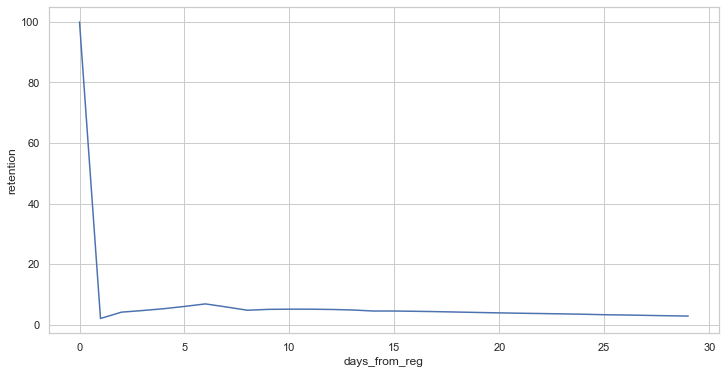

In [12]:
# Визуализируем показатель Retention для пользователей, 
# которые возвращаются в приложение в первый месяц 

sns.lineplot(data=all_cahorts_data.query('days_from_reg < 30'), 
             x="days_from_reg", 
             y="retention")
sns.set()

***Замечание:***

Общее значение Retention имеет резкое падение в первый же день использования приложения, затем небольшой подъем в следующие дни, а после имеет плавный спад. 
Это может происходить по нескольким причинам: 
1. У приложения плохо настроен "онбординг" (первое знакомство пользователя с приложением). 
2. Приложение сложное, и далеко не всем нравится подобный жанр игры, но даже при таком варианте хорошо налаженый процесс обучения  может улучшить ситуацию. Ведь пользователь по какой-то причине заинтересовался приложением (учитываем что это органический трафик пользователей).
3. Плохо настроен трафик пользователей (учитываем что пользовали пришли по платному трафику). В таком случаем, следует обязательно проверить качество закупаемого трафика и его целесообразность (с финансовой точки зрения). Стоит сравнить метрики LTV и CAC для проверки окупаемости привлечения пользователей.

### Функция подсчета Retention по когортам ###

In [13]:
def retention(registration, 
              authorization, 
              start='2018-01-01', 
              days=60, 
              date_format='M'):
    
    """Функция подсчета Retention.

    Ключевые значения:
    registration -- таблица с данными о регистрации пользователей 
                    (указываем переменную, в которую записан датафрейм);
    authorization -- таблица с данными об авторизациях пользователей 
                    (указываем переменную, в которую записан датафрейм);
    start -- дата регистрации, с которой начинаем отсчитывать когорты пользователей 
             (по умолчанию 2018-01-01);
    days -- максимальное количество дней, до которого считаем Retention (по умолчанию 60);
    date_format -- формат даты регистрации для определения кагорт пользователей (по умолчанию M):
                   d - год-месяц-день (разбивка пользователей на кагорты по дням регистрации);
                   M - год-месяц (разбивка пользователей на кагорты по месяцам регистрации);
                   Y - год (разбивка пользователей на кагорты по годам регистрации);
    """
    
    # Импортируем данные по авторизации пользователей.
    # Меняем тип данных и отображение столбца с датой (с формате UNIX на привычный)
    auth_table = pd.read_csv(authorization, sep=';')
    auth_table.auth_ts = pd.to_datetime(auth_table.auth_ts, 
                                        unit='s').dt.normalize()

    # Импортируем данные по регистрации пользователей.
    # Меняем тип данных и отображение столбца с датой (с формате UNIX на привычный)
    reg_table = pd.read_csv(registration, sep=';')
    reg_table.reg_ts = pd.to_datetime(reg_table.reg_ts, 
                                      unit='s').dt.normalize()

    # Объединяем 2 таблицы в одну. Переименовываем колонки для удобства восприятия
    all_table = auth_table.merge(reg_table, 
                                 how='left', 
                                 on='uid') \
                          .rename(columns={'auth_ts': 'auth_date',
                                           'uid': 'id',
                                           'reg_ts': 'reg_date'})
    
    
    # Определяем дату регистрации, с которой начинаем отсчитывать когорты пользователей 
    # (по умолчанию 2020-01-01)
    all_table = all_table.query('reg_date >= "{}"'.format(start))
    
    # Делаем подсчет дней, прошедших с момента регистрации до текущей авторизации
    all_table['days_from_reg'] = (all_table['auth_date']
                                  - all_table['reg_date']).dt.days

    # Определяем формат даты регистрации
    all_table['reg_date'] = all_table['reg_date'].dt.to_period('{}'.format(date_format))

    # Группируем пользователей по дате регистрации и числу дней,
    # прошедших с момента регистрации до текущей авторизации.
    # Считаем число уникальных пользователей по каждой кагорте
    all_table = all_table.groupby(['reg_date', 
                                   'days_from_reg'], as_index=False) \
                         .agg({'id': 'nunique'}) \
                         .rename(columns={'id': 'nunique_id'})

    # Фильтруем пользователей для облегчения визуализации (по умолчанию Retention первого месяца)
    all_table = all_table.query('days_from_reg <= {}'.format(days))
    
    # Транспонируем таблицу, отобразив когорты пользователей (дата регистрации) в индексы,
    # а количество дней с момента регистрации в столбцы.
    all_table = all_table.pivot(index='reg_date',
                                columns='days_from_reg',
                                values='nunique_id')

    # Посчитаем Retention. Значения таблицы (число уникальных пользователей каждой кагорты для каждого дня,
    # прошедшего с момента регистрации до текущей авторизации
    # делим на общее число уникальных пользователей каждой кагорты
    retention_table = (all_table.divide(all_table[0], 
                                        axis=0))

    # Красиво визуализируем таблицу Retention
    viz_retention = (retention_table
                     .style
                     .set_caption('User retention by day')  # добавляем подпись
                     .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                     .highlight_null('white')  # делаем белый фон для значений NaN
                     .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

    return viz_retention

In [14]:
# Пример работы функции. Посмотрим на Retention последних двух лет за первый месяц пользования приложением

retention(file_path_reg, file_path_auth, start='2019-01-01', days=30, date_format='M')

## Вывод ##
   
   1. Важно отметить, что retention резко падает в первый же день. Возможно это указывают на следующее:
         Возможная причина:           
           - сложность игры, имеющую высокий порог входа для пользователей;
           - малый процент людей, которым действительно нравится такой жанр;
           - привлечение большого числа ботов для увелечения количества установок игры.
           
         Необходимые проверки:
           - проверить конверсию активности пользователей с момента установки до завершения прохождения обучающих уровней;
           - проверить каналы привлечения пользователей (найти откуда приходят боты, если они есть);
           - провести A/B тест со снижением уровня сложности начальных уровней (возможно "онбординг" слишком сложен для
           большинства игроков). Ведь те люди, которые начинают погружаться в игру становятся постоянными пользователями
           (долгосрочный retention изменяется незначительно);
   
   2. Заметно падение уровня Retention последнего месяца по сравнению с мясацами ранее. 
         Возможная причина:
           - неудачное обновление;
           - выход на рынок более удачной игры-конкурента;
       
         Необходимые проверки:
           - проверка работоспособности обновления (если оно было) на различных платформах;
           - анализ рынка подобных приложений.
     
     
   3. Заметна тенденция у всех кагорт пользователей, что Retention 2го и 6го дней выше предыдущих. 
      После ~20го дня уровень Retention имеет стаблиьный и более выраженный спад, по сравнению с предыдущими днями использования. 
         Возможная причина:
           - особенности периодических (ежедневных и еженедельных) бонусов в игре;
           - особенностью прохождения уровней.
       
         Необходимые проверки:
           - изучение конверсии прохождения долгосрочных этапов игры и получения бонусов. 
       
   
   
   4. Retention в среднем не меняется для разных кагорт пользователей (до последнего месяца). Это может говорить о том, что обновления серьезно не влияли на поведение пользователей.          
